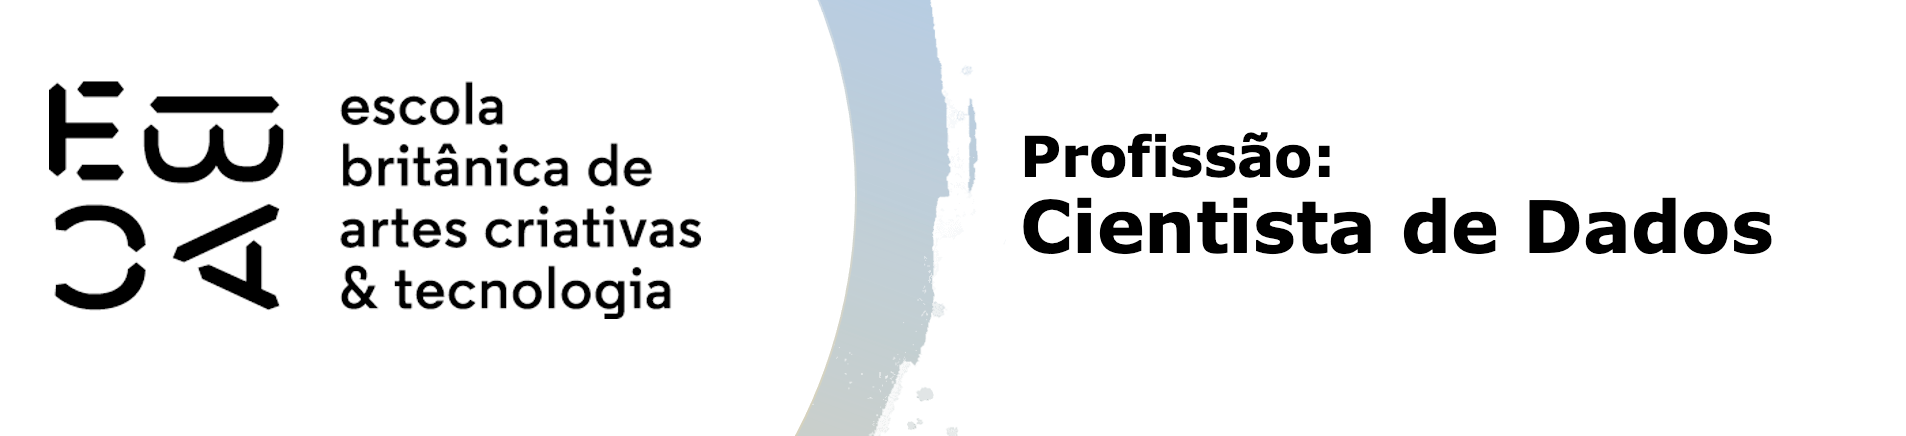

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

# Modelagem e métricas
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, precision_recall_curve, roc_curve, make_scorer,
)
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Pré-processamento
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

# Ferramentas adicionais
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm
from sklearn.utils import resample
from pycaret.classification import *

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Convertendo a coluna 'data_ref' para o formato datetime para manipulação de datas
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Identificando os três últimos meses únicos na coluna 'data_ref' para validação out of time
ultimos_tres_meses = df['data_ref'].unique()[-3:]

# Separando os dados de validação out of time (oot) - esses dados não serão usados no treinamento
df_oot = df[df['data_ref'].isin(ultimos_tres_meses)]

# Separando os dados de treino (todos os dados exceto os de validação oot)
df_treino = df[~df['data_ref'].isin(ultimos_tres_meses)]

# Removendo as colunas 'index' e 'data_ref' dos datasets de treino e validação, pois não serão usadas como variáveis explicativas
df_treino = df_treino.drop(columns=['index', 'data_ref'])
df_oot = df_oot.drop(columns=['index', 'data_ref'])

# Verificando o número de linhas nos conjuntos de treino e validação
print(f"Número de linhas no conjunto de treino: {df_treino.shape[0]}")
print(f"Número de linhas no conjunto de validação oot: {df_oot.shape[0]}")

Número de linhas no conjunto de treino: 600000
Número de linhas no conjunto de validação oot: 150000


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
# Descrição básica da base
num_linhas_total = df.shape[0]
print(f"Número total de linhas: {num_linhas_total}")

# Número de linhas para cada mês em 'data_ref'
linhas_por_mes = df['data_ref'].value_counts().sort_index()
print("\nNúmero de linhas por mês em 'data_ref':")
print(linhas_por_mes)

Número total de linhas: 750000

Número de linhas por mês em 'data_ref':
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [5]:
# Descrição univariada das variáveis qualitativas
print("\nDescrição univariada das variáveis qualitativas:")
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 
                          'tipo_renda', 'educacao', 'estado_civil', 
                          'tipo_residencia', 'mau']
for var in variaveis_qualitativas:
    print(f"\nDescrição de '{var}':")
    print(df[var].value_counts())


Descrição univariada das variáveis qualitativas:

Descrição de 'sexo':
sexo
F    504580
M    245420
Name: count, dtype: int64

Descrição de 'posse_de_veiculo':
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Descrição de 'posse_de_imovel':
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Descrição de 'tipo_renda':
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

Descrição de 'educacao':
educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812
Name: count, dtype: int64

Descrição de 'estado_civil':
estado_civil
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613
Name: count, dtype: int64

Descrição de 'tipo_residencia':
tipo_residencia
Casa             674294
Com os pais       33232
G

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [6]:
# Verificando a presença de valores missing no dataset
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

tempo_emprego    125957
dtype: int64


In [7]:
# Tratando valores ausentes na variável 'tempo_emprego'
# Substituindo valores ausentes pela mediana da variável
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

In [8]:
# Verificando novamente a presença de valores missing no dataset
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [9]:
# Função para tratar outliers baseada no IQR
def tratar_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Tratando os outliers
    df.loc[df[column] < lower_bound, column] = lower_bound
    df.loc[df[column] > upper_bound, column] = upper_bound

# Selecionando colunas numéricas para tratar outliers
num_columns = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Aplicando a função para tratar outliers em cada coluna numérica
for column in num_columns:
    tratar_outliers(df, column)

# Verificando e visualizando sumário estatístico após tratar os outliers
print(df[num_columns].describe())

          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  750000.000000  750000.000000  750000.000000          750000.000000   
mean        0.423100      43.804733       6.961731               2.202521   
std         0.692714      11.229868       4.676414               0.865866   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.635616               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1.000000      53.000000       9.090411               3.000000   
max         2.500000      68.000000      17.272603               4.500000   

               renda  
count  750000.000000  
mean    13035.214824  
std     12665.605731  
min       107.670000  
25%      3467.700000  
50%      7861.820000  
75%     18318.280000  
max     40594.150000  


In [10]:
print(df.dtypes)

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                      float64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                           float64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
dtype: object


In [11]:
# Convertendo variáveis categóricas em variáveis dummy
categorical_columns = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [12]:
print(df.dtypes)

data_ref                         datetime64[ns]
index                                     int64
qtd_filhos                              float64
idade                                   float64
tempo_emprego                           float64
qt_pessoas_residencia                   float64
renda                                   float64
mau                                        bool
sexo_M                                     bool
posse_de_veiculo_S                         bool
posse_de_imovel_S                          bool
tipo_renda_Bolsista                        bool
tipo_renda_Empresário                      bool
tipo_renda_Pensionista                     bool
tipo_renda_Servidor público                bool
educacao_Médio                             bool
educacao_Pós graduação                     bool
educacao_Superior completo                 bool
educacao_Superior incompleto               bool
estado_civil_Separado                      bool
estado_civil_Solteiro                   

In [13]:
# Identificando zeros em colunas importantes
for col in ['tempo_emprego', 'renda']:
    print(f"{col} tem {df[col].isnull().sum()} valores nulos")
    print(f"{col} tem {len(df[df[col] == 0])} valores iguais a zero\n")

tempo_emprego tem 0 valores nulos
tempo_emprego tem 0 valores iguais a zero

renda tem 0 valores nulos
renda tem 0 valores iguais a zero



In [14]:
# Agrupando as categorias de educação
df['educacao_agrupada'] = df.apply(lambda row: 'Ensino Superior' if row['educacao_Superior completo'] == 1 or row['educacao_Superior incompleto'] == 1 else ('Pós-graduação' if row['educacao_Pós graduação'] == 1 else 'Ensino Médio'), axis=1)

# Agrupando as categorias de estado civil
df['estado_civil_agrupado'] = df.apply(lambda row: 'Casado/União' if row['estado_civil_União'] == 1 else ('Outros' if row['estado_civil_Separado'] == 1 or row['estado_civil_Viúvo'] == 1 else 'Solteiro'), axis=1)

# Agrupando as categorias de tipo de residência
df['tipo_residencia_agrupada'] = df.apply(lambda row: 'Alugada' if row['tipo_residencia_Com os pais'] == 1 or row['tipo_residencia_Comunitário'] == 1 or row['tipo_residencia_Estúdio'] == 1 or row['tipo_residencia_Governamental'] == 1 else ('Outros' if row['tipo_residencia_Casa'] == 0 else 'Própria'), axis=1)

In [15]:
# Criando variáveis dummy para as categorias restantes
df = pd.get_dummies(df, columns=['educacao_agrupada', 'estado_civil_agrupado', 'tipo_residencia_agrupada'])

# Separando as variáveis independentes e dependente
X = df.drop(['mau', 'data_ref'], axis=1)  # Remover as colunas 'mau' e 'data_ref'
y = df['mau']  # Variável alvo

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Inicializando e treinando o modelo de Regressão Logística com pesos de classe
class_weights = {0: 1, 1: 10}
model = LogisticRegression(class_weight=class_weights)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight={0: 1, 1: 10})

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [18]:
# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)

# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibindo os resultados da avaliação
print(f"Acurácia do Modelo: {accuracy}")
print(f"Matriz de Confusão: \n{conf_matrix}")
print(f"Relatório de Classificação: \n{class_report}")

Acurácia do Modelo: 0.6248466666666667
Matriz de Confusão: 
[[84426 53878]
 [ 2395  9301]]
Relatório de Classificação: 
              precision    recall  f1-score   support

       False       0.97      0.61      0.75    138304
        True       0.15      0.80      0.25     11696

    accuracy                           0.62    150000
   macro avg       0.56      0.70      0.50    150000
weighted avg       0.91      0.62      0.71    150000



In [19]:
# Criando o modelo XGBoost
xgb_model = XGBClassifier(random_state=42)

# Treinando o modelo XGBoost com os dados de treino
xgb_model.fit(X_train_scaled, y_train)

# Fazendo previsões no conjunto de teste
xgb_predictions = xgb_model.predict(X_test_scaled)

# Avaliando o modelo
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_confusion_matrix = confusion_matrix(y_test, xgb_predictions)
xgb_classification_report = classification_report(y_test, xgb_predictions)

# Exibindo os resultados da avaliação
print(f"Acurácia do Modelo XGBoost: {xgb_accuracy}")
print(f"Matriz de Confusão: \n{xgb_confusion_matrix}")
print(f"Relatório de Classificação: \n{xgb_classification_report}")

Acurácia do Modelo XGBoost: 0.9222266666666666
Matriz de Confusão: 
[[137986    318]
 [ 11348    348]]
Relatório de Classificação: 
              precision    recall  f1-score   support

       False       0.92      1.00      0.96    138304
        True       0.52      0.03      0.06     11696

    accuracy                           0.92    150000
   macro avg       0.72      0.51      0.51    150000
weighted avg       0.89      0.92      0.89    150000



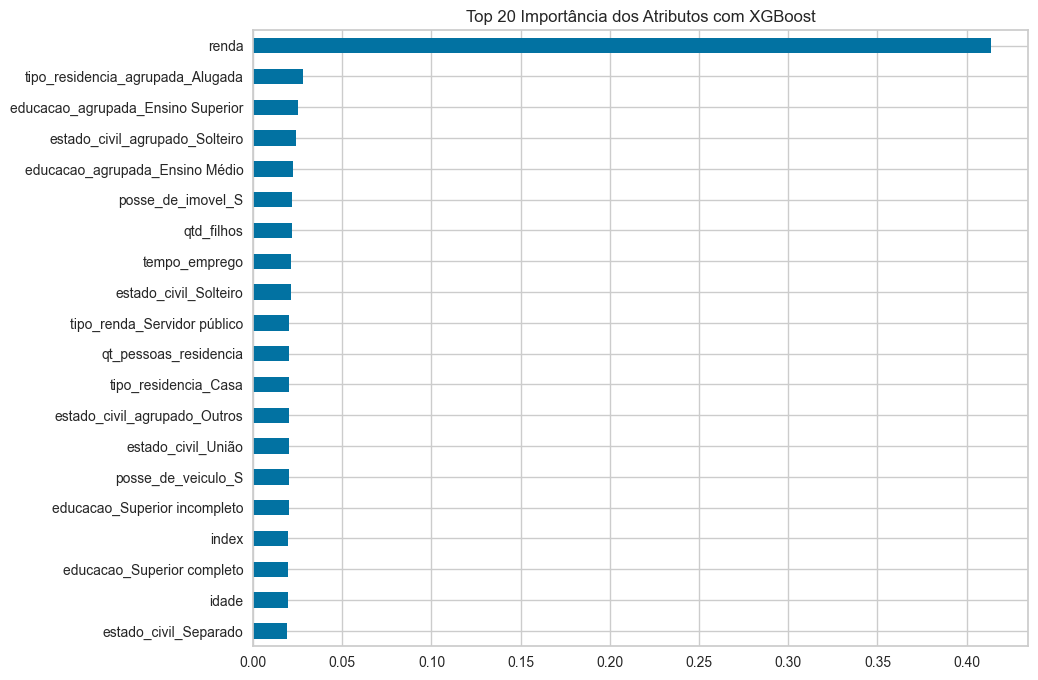

In [20]:
# Inicializando o modelo XGBoost
xgb_model = XGBClassifier(random_state=42)

# Treinando o modelo com os dados completos
xgb_model.fit(X, y)

# Obtendo a importância dos atributos e armazenando em um DataFrame
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)

# Visualizando a importância dos atributos com um gráfico de barras horizontal e limitando aos top 20
top_n = 20
(feature_importances_xgb
    .sort_values(ascending=True) # Isso garante que os mais importantes ficam no topo
    .tail(top_n) # Seleciona os top N mais importantes
    .plot(kind='barh', figsize=(10,8), title='Top 20 Importância dos Atributos com XGBoost')) # gráfico de barras horizontal com tamanho aumentado
plt.show() # Mostra o gráfico

In [21]:
# Desativar avisos de futuras mudanças
warnings.simplefilter(action='ignore', category=FutureWarning)

# Análise de Correlação
# Inicialmente, vamos calcular a matriz de correlação para o dataframe.
correlation_matrix = df.corr()

# Mostramos as correlações da variável alvo 'mau' em ordem decrescente.
target_correlation = correlation_matrix['mau'].sort_values(ascending=False)
print(target_correlation)

mau                                   1.000000
data_ref                              0.070538
tipo_residencia_Com os pais           0.013215
educacao_agrupada_Ensino Médio        0.013022
educacao_Médio                        0.011673
tipo_residencia_agrupada_Alugada      0.010454
index                                 0.009360
tipo_renda_Pensionista                0.007529
qtd_filhos                            0.006572
estado_civil_agrupado_Casado/União    0.006124
estado_civil_União                    0.006124
tipo_residencia_agrupada_Outros       0.005271
estado_civil_Solteiro                 0.004217
educacao_Superior incompleto          0.003621
qt_pessoas_residencia                 0.003405
estado_civil_Separado                 0.003270
tipo_residencia_Governamental         0.002689
tipo_residencia_Comunitário           0.001560
estado_civil_agrupado_Outros          0.000657
educacao_Pós graduação               -0.000678
educacao_agrupada_Pós-graduação      -0.000678
estado_civil_

In [ ]:
## Padronização dos Dados
# Iniciando o objeto StandardScaler para padronizar os dados para ter média 0 e variância 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Aplica a padronização aos dados.

## Criando modelo de regressão Logística e criando uma instância do modelo LogisticRegression.
logistic_model = LogisticRegression()

## Selecionando características com RFECV
# Iniciando o RFECV com o modelo de regressão logística para seleção de recursos.
rfecv = RFECV(
    estimator=logistic_model, 
    step=1, 
    cv=StratifiedKFold(5), 
    scoring='accuracy'
)

# Treinando o RFECV com os dados padronizados e a variável alvo 'y'.
rfecv.fit(X_scaled, y)

## Resultados do RFECV
# Imprimindo o número ótimo de recursos e as características selecionadas pelo RFECV.
print("Número ótimo de características: %d" % rfecv.n_features_)
print('Características selecionadas: %s' % list(X.columns[rfecv.support_]))

In [ ]:
# Construindo a tabela de contingência entre 'mau' e 'sexo_M'
contingency_table = pd.crosstab(df['mau'], df['sexo_M'])  # Substitua 'sexo_M' pela sua variável categórica.

# Realização do teste de qui-quadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Exibição do p-valor para determinar a associação
print(f"P-value: {p}")

In [ ]:
# Avaliando o modelo RandomForestClassifier com validação cruzada
scores = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5)

# Exibindo a acurácia média
print("Acurácia média com validação cruzada: %0.2f" % scores.mean())

In [ ]:
# Exemplo para uma variável categórica 'categoria'
contingency_table = pd.crosstab(df['mau'], df['sexo_M'])  # Substitua 'categoria' pela variável categórica
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"P-value: {p}")

In [ ]:

scores = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5)
print("Acurácia média com validação cruzada: %0.2f" % scores.mean())

In [ ]:

# Treinando o modelo com o conjunto de treinamento (X_train, y_train)
model.fit(X_train, y_train)

# Realizando previsões com o conjunto de teste (X_test)
y_pred = model.predict(X_test)

# Calculando e imprimindo a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")

In [ ]:
# Calculando as probabilidades de previsão
y_prob = model.predict_proba(X_test)[:, 1]

# Calculando e imprimindo KS e Gini usando as probabilidades e as classes reais (y_test)
ks_statistic = ks_2samp(y_test, y_prob).statistic
gini_coefficient = 2 * roc_auc_score(y_test, y_prob) - 1

print(f"KS Statistic: {ks_statistic}")
print(f"Gini Coefficient: {gini_coefficient}")

In [ ]:
# Definindo os passos do pipeline
# O primeiro elemento da tupla é um identificador do passo (string) e o segundo é um objeto transformador ou estimador
steps = [
    # Passo de padronização dos dados
    ('scaler', StandardScaler()),
    # Passo do modelo de regressão logística
    ('logistic_regression', LogisticRegression())
]

# Criando o pipeline
pipeline = Pipeline(steps)

# Ajustando o pipeline aos dados de treino
# X_train e y_train devem ser seus dados de treino
pipeline.fit(X_train, y_train)

# Fazendo previsões com o pipeline
# X_test é o seu conjunto de teste
y_pred = pipeline.predict(X_test)

# Avaliando o modelo
# y_test são as verdadeiras etiquetas do conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [ ]:
# Identificar a quantidade de valores nulos em cada coluna
nulos = df.isnull().sum()

# Calcular a proporção de valores nulos em cada coluna
proporcao_nulos = df.isnull().mean()

# Exibir as colunas com valores nulos e suas respectivas quantidades e proporções
# Isso nos ajudará a entender a extensão dos dados ausentes em nosso dataframe
colunas_com_nulos = nulos[nulos > 0]
proporcoes_com_nulos = proporcao_nulos[proporcao_nulos > 0]
print("Colunas com valores nulos, quantidade e proporção:")
print(pd.concat([colunas_com_nulos, proporcoes_com_nulos], axis=1, keys=['Quantidade', 'Proporção']))

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [ ]:
# Calculando o IQR para a coluna 'renda'
Q1 = df['renda'].quantile(0.25)
Q3 = df['renda'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites inferior e superior para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificando os outliers na coluna 'renda'
outliers = df[(df['renda'] < lower_bound) | (df['renda'] > upper_bound)]
print(f"Quantidade de outliers: {outliers.shape[0]}")

# Visualizando os outliers com um boxplot
sns.boxplot(x=df['renda'])
plt.title('Boxplot de Renda')
plt.show()

In [ ]:
# Remover outliers
X_digits_clean = X_digits[~outliers.any(axis=1)]

In [ ]:
sns.boxplot(x=df['renda'])
plt.show()

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [ ]:
print(df.columns)

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Definir modelo random forest
rf = RandomForestClassifier(n_jobs=-1, max_depth=5)

# Aplicar Boruta
boruta = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta.fit(X.values, y)

# Obter as variáveis selecionadas
selected_features = X.columns[boruta.support_]
print("Variáveis selecionadas pelo Boruta:", selected_features)


In [ ]:
# Removendo a coluna 'index' e 'data_ref'
df = df.drop(columns=['index', 'data_ref'])

# Definindo as variáveis independentes (X) e a variável dependente (y)
X = df.drop('mau', axis=1)
y = df['mau']

# Inicializando e treinando o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Calculando e exibindo a importância das variáveis
feature_importances = rf.feature_importances_
features = X.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Ordenando as características por importância
importances_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importances_df)

# Visualizando a importância das características em um gráfico
importances_df.plot(kind='bar', x='Feature', y='Importance')
plt.title('Importância das Características - Random Forest')
plt.ylabel('Importância')
plt.xlabel('Características')
plt.show()

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [ ]:
# Removendo as colunas que não serão utilizadas na análise
df_reduced = df.drop(columns=['mau'])

# Normalização dos dados para garantir que todas as características tenham igual importância
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_reduced)

# Aplicando do PCA para reduzir a dimensionalidade para 5 componentes principais
pca = PCA(n_components=5)
principal_components = pca.fit_transform(df_normalized)

# Convertendo os componentes principais em um DataFrame para análise
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Exibindo as primeiras linhas do DataFrame PCA
print("Primeiras linhas do DataFrame PCA:")
print(df_pca.head())

# Exibindo a variância explicada por cada componente principal
print("\nVariância explicada por cada componente principal:")
print(pca.explained_variance_ratio_)

In [ ]:
def remove_outliers(X):
    # Índices das colunas quantitativas
    indices_quantitativos = [0, 1, 2, 3, 4]  # Os índices correspondem às colunas ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
    
    # Convertendo o array NumPy em um DataFrame do Pandas
    X_df = pd.DataFrame(X)
    
    # Selecionando apenas as colunas quantitativas usando índices
    X_quantitativo = X_df.iloc[:, indices_quantitativos]
    
    # Removendo outliers utilizando o método do intervalo interquartílico
    Q1 = X_quantitativo.quantile(0.25)
    Q3 = X_quantitativo.quantile(0.75)
    IQR = Q3 - Q1
    
    # Definindo um limite para considerar um valor como outlier (geralmente 1.5 * IQR)
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Aplicando os limites para remover os outliers
    mask = ~((X_quantitativo < (limite_inferior)) | (X_quantitativo > (limite_superior))).any(axis=1)
    X_sem_outliers = X_df[mask]
    
    # Retornando apenas as linhas sem outliers para todas as colunas
    return X_sem_outliers.values

In [ ]:
import pandas as pd

# Função de pré-processamento exemplo
def preprocessamento(df):
    # Substituir valores nulos por médias (como exemplo)
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        df[column] = df[column].fillna(df[column].mean())
    return df


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

# Exemplo da função remove_outliers
def remove_outliers(df):
    # Remover outliers com base em um critério (exemplo: valores fora de 3 desvios padrão)
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        mean = df[column].mean()
        std = df[column].std()
        df = df[(df[column] >= mean - 3 * std) & (df[column] <= mean + 3 * std)]
    return df

# Transformer que você mencionou no erro
preprocessing_steps = ColumnTransformer(
    transformers=[
        # Adicione aqui os transformadores para diferentes tipos de colunas
        # Por exemplo, substituindo nulos por médias nas colunas numéricas
    ],
    remainder='passthrough'
)

# Pipeline completo
pipeline = Pipeline(steps=[
    ('preprocess', FunctionTransformer(preprocessamento, validate=False)),
    ('preprocessing_steps', preprocessing_steps),
    ('remove_outliers', FunctionTransformer(remove_outliers, validate=False)),
    ('pca', PCA(n_components=2))
])


In [ ]:
import pandas as pd

def remove_outliers(df):
    # Garantir que df seja um DataFrame
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)

    # Remover outliers com base em um critério (exemplo: valores fora de 3 desvios padrão)
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        mean = df[column].mean()
        std = df[column].std()
        df = df[(df[column] >= mean - 3 * std) & (df[column] <= mean + 3 * std)]
    
    return df


In [ ]:

# Dividindo os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=42)

# Treinando o modelo de regressão logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Prevendo no conjunto de teste
y_pred = logreg.predict(X_test)

# Avaliando o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy*100:.2f}%")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))

In [ ]:
# Treinando modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicando SMOTE para balancear os dados de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Criando o modelo XGBoost
xgb_model = XGBClassifier(random_state=42)

# Treinando o modelo XGBoost com os dados balanceados pelo SMOTE
xgb_model.fit(X_train_smote, y_train_smote)

# Fazendo previsões no conjunto de teste
xgb_predictions = xgb_model.predict(X_test)

# Avaliando o modelo
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_confusion_matrix = confusion_matrix(y_test, xgb_predictions)
xgb_classification_report = classification_report(y_test, xgb_predictions)

print(f"Acurácia do Modelo XGBoost: {xgb_accuracy}")
print(f"Matriz de Confusão: \n{xgb_confusion_matrix}")
print(f"Relatório de Classificação: \n{xgb_classification_report}")

In [ ]:
# Definindo o modelo XGBoost ajustando scale_pos_weight para tratar o desbalanceamento
ratio = float(np.sum(y_train_smote == 0)) / np.sum(y_train_smote == 1)
xgb_model = XGBClassifier(scale_pos_weight=ratio, random_state=42)

# Definindo a grade de hiperparâmetros a ser testada
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1, 0.2]
}

# Atualizando para usar a barra de progresso do tqdm para Jupyter Notebook
class TqdmGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        """ Substituir o método 'evaluate_candidates' com tqdm para a barra de progresso """
        for params in tqdm(ParameterGrid(self.param_grid), 
                           total=len(ParameterGrid(self.param_grid)), 
                           leave=False):
            evaluate_candidates([params])

# Ajustando o GridSearchCV com uma métrica de avaliação focada em desequilíbrio
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search = TqdmGridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               scoring=roc_auc_scorer, cv=3, verbose=0, n_jobs=-1)

# Fit do GridSearchCV nos dados de treinamento
grid_search.fit(X_train_smote, y_train_smote)

# Exibindo os melhores hiperparâmetros encontrados
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

# Avaliando o melhor modelo encontrado pelo GridSearchCV no conjunto de teste
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Avaliando o desempenho do melhor modelo
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

print(f"Acurácia do Melhor Modelo XGBoost: {accuracy}")
print(f"Matriz de Confusão do Melhor Modelo: \n{conf_matrix}")
print(f"Relatório de Classificação do Melhor Modelo: \n{class_report}")

In [ ]:
from sklearn.utils import resample

X_train_sample, y_train_sample = resample(
X_train_smote,
y_train_smote,
replace=False,
n_samples=int(0.1 * len(y_train_smote)),
random_state=42)

In [ ]:
X_train_sample, y_train_sample = resample(
    X_train_smote,
    y_train_smote,
    replace=False,
    n_samples=int(0.1 * len(y_train_smote)),
    random_state=42
)

In [ ]:
# Ajustando o modelo com os melhores hiperparâmetros no conjunto de amostras
best_model.fit(X_train_sample, y_train_sample)

# Obtendo as probabilidades previstas para a classe de interesse (geralmente classe 1 para binário)
y_probas = best_model.predict_proba(X_test)[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probas)

# Encontrando o limiar que otimiza o recall para a classe minoritária
# (Isso pode ser feito buscando o ponto mais próximo do topo esquerdo do gráfico ROC (menor fpr, maior tpr))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
print('Melhor Limiar=%f, G-Mean=%.3f' % (best_threshold, gmeans[ix]))

# Calculando as predições baseadas no novo limiar
predictions = (y_probas >= best_threshold).astype(int)

# Avaliando o desempenho após ajuste do limiar
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

print(f"Acurácia após ajuste do limiar: {accuracy}")
print(f"Matriz de Confusão após ajuste do limiar: \n{conf_matrix}")
print(f"Relatório de Classificação após ajuste do limiar: \n{class_report}")

In [ ]:
# Calculando as probabilidades de previsão
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculando precisão e recall para vários limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculand a pontuação F1 para cada limiar
f1_scores = 2*recall*precision / (recall + precision + 1e-8)

# Encontrando o índice do maior pontuação F1
ix = np.argmax(f1_scores)
print(f"Melhor Limiar={thresholds[ix]}, F1-Score={f1_scores[ix]}")

# Plotando a curva Precision-Recall
plt.figure(figsize=(10,6))
plt.plot(recall, precision, label='Curva Precision-Recall')
plt.scatter(recall[ix], precision[ix], marker='o', color='red', label='Melhor')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

In [ ]:
# Definir o nome do arquivo onde o modelo treinado será salvo
nome_arquivo = 'model_final.pkl'

# Utilizar o método `dump` do módulo pickle para salvar o modelo
# 'wb' indica que o arquivo está aberto para escrita em modo binário
pickle.dump(model, open(nome_arquivo, 'wb'))

# Uma vez executado, o modelo estará salvo no arquivo 'model_final.pkl'
# e pode ser carregado posteriormente usando pickle.load()

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [ ]:
# Carregamento dos dados
df = pd.read_feather('credit_scoring.ftr')

# Exibindo as primeiras linhas do DataFrame
df.head()

In [ ]:
# Inicializando a configuração do PyCaret no ambiente
clf1 = setup(data=df, target='mau', session_id=123)

In [ ]:
# Comparando todos os modelos disponíveis para encontrar o melhor
best_model = compare_models()

In [ ]:
# Criando o modelo LightGBM
lgbm = create_model('lightgbm')

In [ ]:
# Afinação do modelo para melhorar o desempenho
tuned_lgbm = tune_model(lgbm)

In [ ]:
# Avaliando o modelo afiado
evaluate_model(tuned_lgbm)

In [ ]:
# Plotar gráficos importantes
plot_model(tuned_lgbm, plot='auc')
plot_model(tuned_lgbm, plot='confusion_matrix')

In [ ]:
# Finalizar o modelo para fazer previsões em dados não vistos
final_lgbm = finalize_model(tuned_lgbm)

In [ ]:
# Salvando o modelo finalizado
save_model(final_lgbm, 'final_lgbm_model')